# 12_nndl_cv_mlp2

We will experiment with Neural Networks and Deep Learning on the no_na dataset. This is mlp2, our second version of multi-layer perceptron 

# Difference from mlp1 - no dropout on the input layer

In [ ]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

''' preprocessing '''
from sklearn.preprocessing import StandardScaler

In [ ]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [ ]:
# load data
train = pd.read_csv(root_dir/"data/train_no_na.csv")
test = pd.read_csv(root_dir/"data/test_no_na.csv")
print("data loaded")

data loaded


In [ ]:
# check shape
print(train.shape)
print(test.shape)

(279331, 138)
(120163, 138)


In [ ]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


# Helper functions

In [ ]:
# constants
SEED = 42

# cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=SEED, shuffle=True)

In [ ]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [ ]:
def model_scores(model, test, x_test, y_test):
  y_pred = model.predict(x_test) 
  y_pred = (y_pred > 0.5).astype(int)
  
  # # get some scores from helpers
  utility = utility_score(test, y_pred)
  accuracy =  accuracy_score(y_test, y_pred)

  # # confusion matrix
  # print("confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  true_pos = cm[1][1]
  true_neg = cm[0][0]
  false_pos = cm[0][1]
  false_neg = cm[1][0]

  # # plot confusion matrix
  # fig, ax = plt.subplots(figsize=(3, 3))
  # ax.imshow(cm)
  # ax.grid(False)
  # ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  # ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  # ax.set_ylim(1.5, -0.5)
  # for i in range(2):
  #     for j in range(2):
  #         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  # plt.show()  

  # # AUC-ROC
  # print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, y_pred)

  # # plot auc-roc
  # fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  # plt.figure()
  # plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  # plt.plot([0, 1], [0, 1],'r--')
  # plt.xlim([0.0, 1.0])
  # plt.ylim([0.0, 1.05])
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('Receiver operating characteristic')
  # plt.legend(loc="lower right")
  # plt.show()

  return utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg

In [ ]:
import datetime
import csv

def save_scores(output_filename, workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg):
  # create output file if not exists
  try:
    f = open(root_dir/output_filename)
  except IOError:
    with open (root_dir/output_filename, 'a') as csvfile:
      headers = ["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"]
      writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n',fieldnames=headers)
      writer.writeheader() 
      print("created output file")  
    csvfile.close()

  # output file exists, append
  timestamp = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  
  ''' create another df that looks just like the excel file and concat with ''' 
  new_scores = pd.DataFrame(np.array([[workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg, timestamp]]),
                   columns=["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"],
                  )

  new_scores.to_csv(root_dir/output_filename, mode='a', header=False, index=False)
  print("saved model metrics")

In [ ]:
'''
used to generate the PosixPath variables for the results to save
'''
def results_paths(root_dir=root_dir):
    PATH_RESULTS = root_dir /'results_nndl'
    PATH_HISTORIES = PATH_RESULTS / 'histories'
    PATH_FIGURES = PATH_RESULTS / 'figures'
    PATH_CHECKPOINTS = PATH_RESULTS / 'checkpoints'
    PATH_PREDICTIONS = PATH_RESULTS / 'predictions'

    return PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS


''' 
used to save the history of a model as a npy file
'''
# filename like 'history/model_name.npy'
def history_saver(history, model_name, history_save_path, already_npy=False):
  history_json = {}

  if already_npy:
    history_npy = history
  else:
    history_npy = history.history

  np.save(history_save_path/model_name, history_npy)
  print("History saved")



''' 
used to load the history of a model from a npy file
'''
# filename like 'history/model_name.npy'
def history_loader(model_name, history_save_path):
  history_save_path = history_save_path/str(model_name+'.npy')
  history=np.load(history_save_path,allow_pickle='TRUE').item()
  print('History loaded')
  
  return history 

'''
used to plot the metrics for a given history
'''
def plot_metrics(history, model_name, figure_save_path):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # print(history.keys())

    # plot losses
    train_loss = history['loss']
    val_loss = history['val_loss']
    loss_title = 'loss against epochs'

    ax1.plot(train_loss, label='train')
    ax1.plot(val_loss, label='val')
    ax1.set_title(loss_title)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax1.legend()

    # plot accuracy_score
    accuracy_score = history['accuracy']
    val_accuracy_score = history['val_accuracy']
    accuracy_score_title = 'accuracy_score against epochs'

    ax2.plot(accuracy_score, label='train')
    ax2.plot(val_accuracy_score, label='val')
    ax2.set_title(accuracy_score_title)
    ax2.set_ylabel('accuracy_score')
    ax2.set_xlabel('epochs')
    ax2.legend()


    # plot accuracy_score
    auc_score = history['auc']
    val_auc_score = history['val_auc']
    auc_score_title = 'auc_score against epochs'

    ax3.plot(auc_score, label='train')
    ax3.plot(val_auc_score, label='val')
    ax3.set_title(auc_score_title)
    ax3.set_ylabel('auc_score')
    ax3.set_xlabel('epochs')
    ax3.legend()


    # save figure
    fig.suptitle('Metrics for model: ' + model_name)
    plt.savefig(figure_save_path/f'{model_name}.png')

    plt.show()  

# Neural Network - Model 2 (Activations)

In [ ]:
!pip install keras_tqdm

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

from keras_tqdm import TQDMCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, AUC

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS = results_paths()

In [ ]:
def create_mlp(num_columns, hidden_units, activation, dropout_rates, learning_rate): 
  inp = Input(shape=(num_columns,))
  x = BatchNormalization()(inp)

  for i in range(len(hidden_units)):   
    x = Dense(hidden_units[i])(x)
    x = Activation(activation)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[i])(x)

  x = Dense(1)(x)
  out = Activation("sigmoid")(x)

  model = Model(inputs=inp, outputs=out)

  model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(label_smoothing=1e-4),
    metrics=[BinaryAccuracy(name="accuracy"), AUC(name="auc")]
  )

  return model

In [ ]:
# settings to vary

# epochs default = [50] going forward for training due to time constraints, final evaluation put about 1000 to try and achieve convergence
epochs = [50] 

# batch_sizes default = [512] going forward for training due to time constraints, final evaluation can be batch size of 128/256 to achieve better utility scores
batch_sizes = [512]

# hidden_units default = [200, 400, 800, 400] going forward for training due to time constraints, final evaluation can be greater number of hidden units to achieve better utility scores
hidden_units = [
    [200, 400, 800, 400]
]

# dropout_rates should have same number of values as hidden_units
# dropout_rates default = [0.2, 0.2, 0.2, 0.2] going forward for training due to very poor performance of 0.4, and 0 provides no regularizing effect (model has not converged yet)
dropout_rates = [
    [0.2, 0.2, 0.2, 0.2]
] 

# activations default = [tf.keras.activations.relu]
activations = [tf.keras.activations.relu, tf.keras.activations.sigmoid, tf.keras.activations.tanh]

# learning_rates default = [1e-4]
learning_rates = [1e-4]


model_name:  mlp2_activations_<function relu at 0x7f2398153440>
model_params:  batch_size=512, hidden_unit=[200, 400, 800, 400], activation=<function relu at 0x7f2398153440>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 8s 8ms/step - loss: 0.8101 - accuracy: 0.5052 - auc: 0.5081 - val_loss: 0.6935 - val_accuracy: 0.5357 - val_auc: 0.5485
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7371 - accuracy: 0.5169 - auc: 0.5256 - val_loss: 0.6881 - val_accuracy: 0.5415 - val_auc: 0.5592
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7215 - accuracy: 0.5213 - auc: 0.5305 - val_loss: 0.6853 - val_accuracy: 0.5443 - val_auc: 0.5666
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7129 - accuracy: 0.5253 - auc: 0.5355 - val_loss: 0.6842 - val_accuracy: 0.5501 - val_auc: 0.5705
Epoch 5/50
492/492 [====================

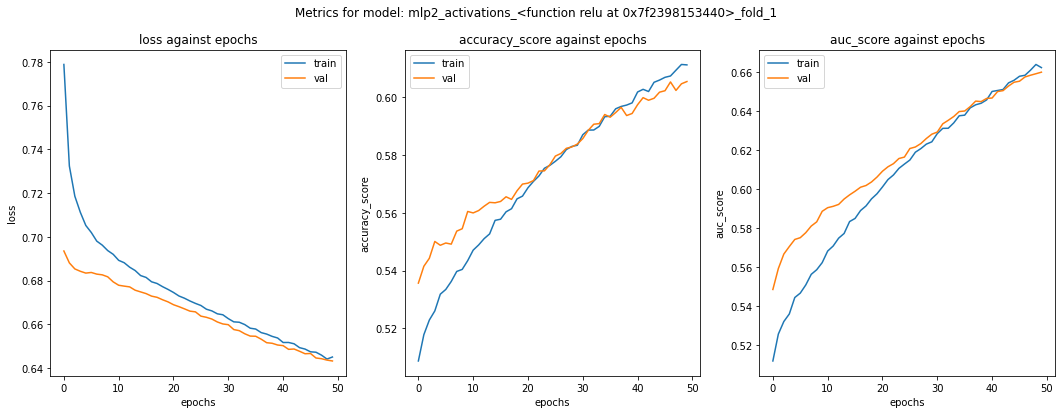

training model fold 2
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8193 - accuracy: 0.5094 - auc: 0.5131 - val_loss: 0.6958 - val_accuracy: 0.5356 - val_auc: 0.5487
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7440 - accuracy: 0.5159 - auc: 0.5236 - val_loss: 0.6871 - val_accuracy: 0.5430 - val_auc: 0.5659
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7258 - accuracy: 0.5204 - auc: 0.5288 - val_loss: 0.6862 - val_accuracy: 0.5474 - val_auc: 0.5694
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7150 - accuracy: 0.5247 - auc: 0.5351 - val_loss: 0.6832 - val_accuracy: 0.5485 - val_auc: 0.5750
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7069 - accuracy: 0.5328 - auc: 0.5445 - val_loss: 0.6833 - val_accuracy: 0.5516 - val_auc: 0.5760
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7031 - accuracy: 0.5304 - auc: 0

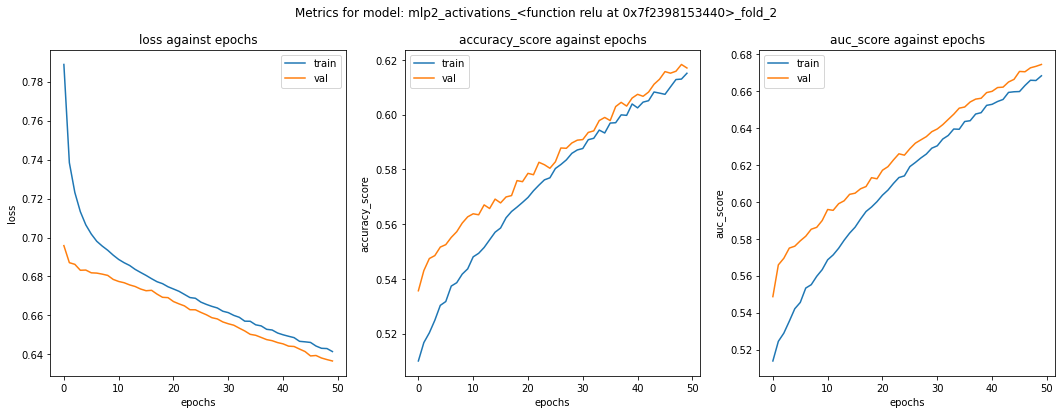

training model fold 3
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8174 - accuracy: 0.5080 - auc: 0.5109 - val_loss: 0.6965 - val_accuracy: 0.5316 - val_auc: 0.5449
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7419 - accuracy: 0.5182 - auc: 0.5238 - val_loss: 0.6889 - val_accuracy: 0.5392 - val_auc: 0.5589
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7236 - accuracy: 0.5220 - auc: 0.5293 - val_loss: 0.6873 - val_accuracy: 0.5417 - val_auc: 0.5618
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7151 - accuracy: 0.5245 - auc: 0.5326 - val_loss: 0.6881 - val_accuracy: 0.5431 - val_auc: 0.5646
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7078 - accuracy: 0.5290 - auc: 0.5410 - val_loss: 0.6857 - val_accuracy: 0.5460 - val_auc: 0.5697
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7039 - accuracy: 0.5308 - auc: 0

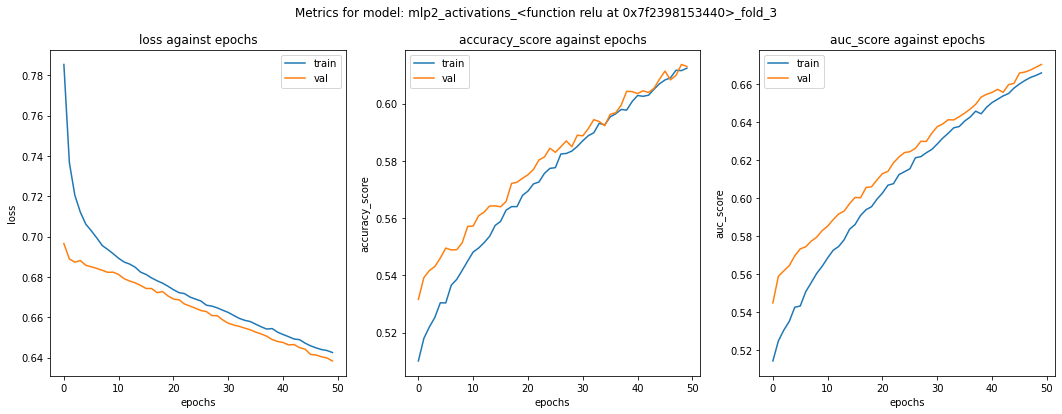

training model fold 4
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8126 - accuracy: 0.5077 - auc: 0.5098 - val_loss: 0.7003 - val_accuracy: 0.5286 - val_auc: 0.5434
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7425 - accuracy: 0.5183 - auc: 0.5230 - val_loss: 0.6873 - val_accuracy: 0.5454 - val_auc: 0.5644
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7228 - accuracy: 0.5205 - auc: 0.5295 - val_loss: 0.6870 - val_accuracy: 0.5462 - val_auc: 0.5699
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7132 - accuracy: 0.5257 - auc: 0.5369 - val_loss: 0.6840 - val_accuracy: 0.5504 - val_auc: 0.5744
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7065 - accuracy: 0.5285 - auc: 0.5403 - val_loss: 0.6840 - val_accuracy: 0.5560 - val_auc: 0.5784
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7026 - accuracy: 0.5347 - auc: 0

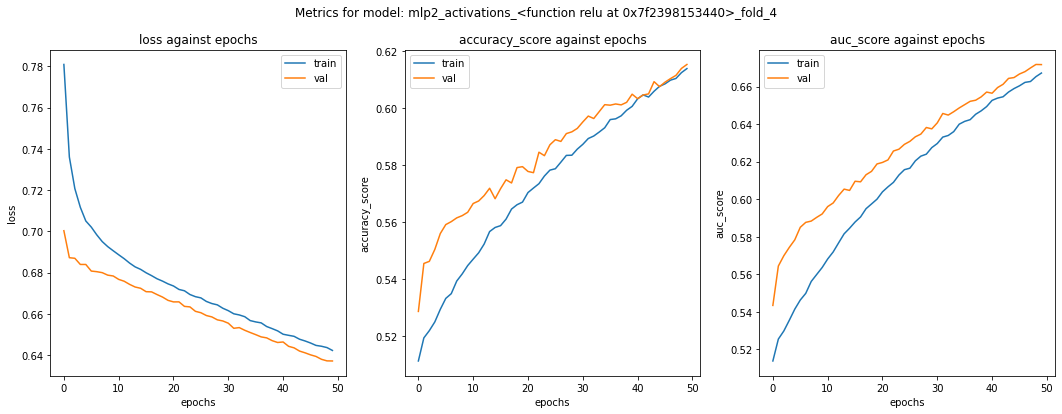

training model fold 5
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8199 - accuracy: 0.5055 - auc: 0.5077 - val_loss: 0.6970 - val_accuracy: 0.5312 - val_auc: 0.5495
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7436 - accuracy: 0.5160 - auc: 0.5232 - val_loss: 0.6886 - val_accuracy: 0.5378 - val_auc: 0.5593
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7248 - accuracy: 0.5216 - auc: 0.5306 - val_loss: 0.6855 - val_accuracy: 0.5443 - val_auc: 0.5656
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7137 - accuracy: 0.5256 - auc: 0.5356 - val_loss: 0.6863 - val_accuracy: 0.5466 - val_auc: 0.5651
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7069 - accuracy: 0.5287 - auc: 0.5425 - val_loss: 0.6833 - val_accuracy: 0.5471 - val_auc: 0.5727
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7026 - accuracy: 0.5336 - auc: 0

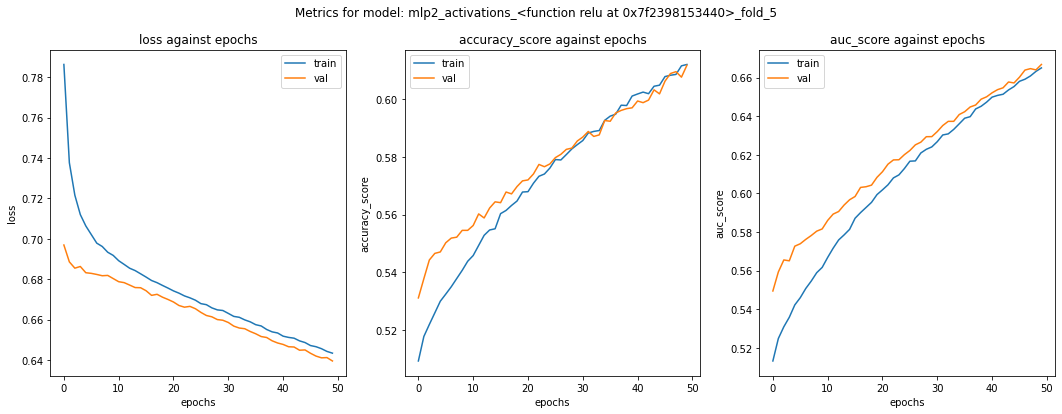

training model fold 6
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8071 - accuracy: 0.5085 - auc: 0.5110 - val_loss: 0.6952 - val_accuracy: 0.5325 - val_auc: 0.5466
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7370 - accuracy: 0.5181 - auc: 0.5245 - val_loss: 0.6903 - val_accuracy: 0.5394 - val_auc: 0.5590
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7204 - accuracy: 0.5221 - auc: 0.5315 - val_loss: 0.6892 - val_accuracy: 0.5399 - val_auc: 0.5605
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7134 - accuracy: 0.5255 - auc: 0.5356 - val_loss: 0.6859 - val_accuracy: 0.5451 - val_auc: 0.5658
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7052 - accuracy: 0.5295 - auc: 0.5432 - val_loss: 0.6838 - val_accuracy: 0.5481 - val_auc: 0.5732
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7002 - accuracy: 0.5328 - auc: 0

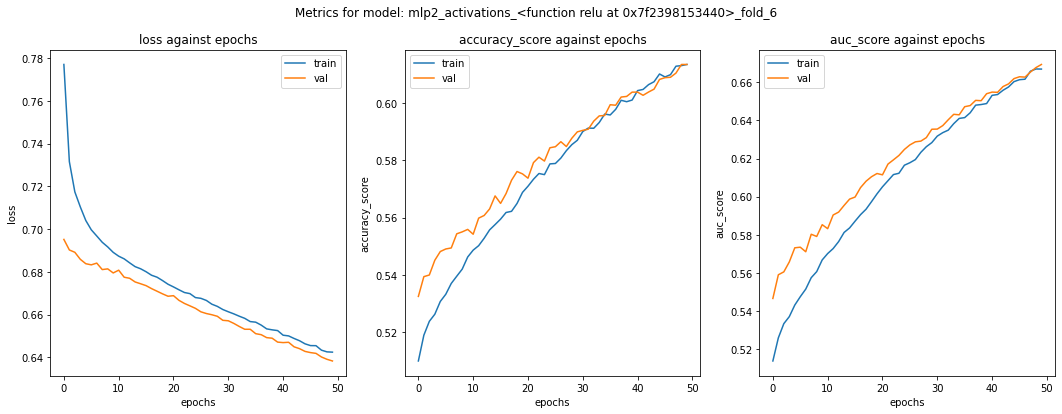

training model fold 7
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8144 - accuracy: 0.5092 - auc: 0.5112 - val_loss: 0.6958 - val_accuracy: 0.5319 - val_auc: 0.5475
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7404 - accuracy: 0.5187 - auc: 0.5256 - val_loss: 0.6938 - val_accuracy: 0.5301 - val_auc: 0.5572
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7239 - accuracy: 0.5213 - auc: 0.5297 - val_loss: 0.6855 - val_accuracy: 0.5427 - val_auc: 0.5675
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7125 - accuracy: 0.5273 - auc: 0.5366 - val_loss: 0.6851 - val_accuracy: 0.5444 - val_auc: 0.5663
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7071 - accuracy: 0.5320 - auc: 0.5436 - val_loss: 0.6835 - val_accuracy: 0.5462 - val_auc: 0.5731
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7019 - accuracy: 0.5334 - auc: 0

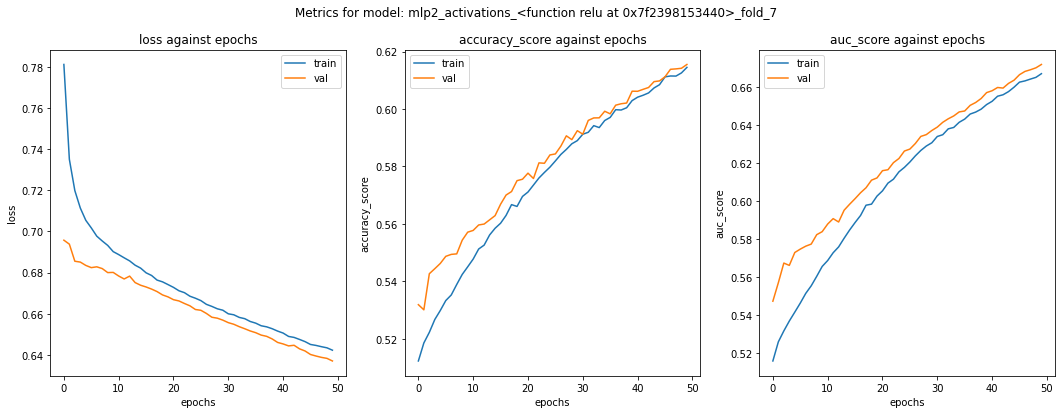

training model fold 8
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8101 - accuracy: 0.5074 - auc: 0.5099 - val_loss: 0.6935 - val_accuracy: 0.5369 - val_auc: 0.5518
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7384 - accuracy: 0.5183 - auc: 0.5252 - val_loss: 0.6882 - val_accuracy: 0.5416 - val_auc: 0.5593
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7231 - accuracy: 0.5206 - auc: 0.5286 - val_loss: 0.6859 - val_accuracy: 0.5493 - val_auc: 0.5668
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7111 - accuracy: 0.5274 - auc: 0.5389 - val_loss: 0.6874 - val_accuracy: 0.5476 - val_auc: 0.5684
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7070 - accuracy: 0.5313 - auc: 0.5432 - val_loss: 0.6841 - val_accuracy: 0.5488 - val_auc: 0.5732
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7025 - accuracy: 0.5320 - auc: 0

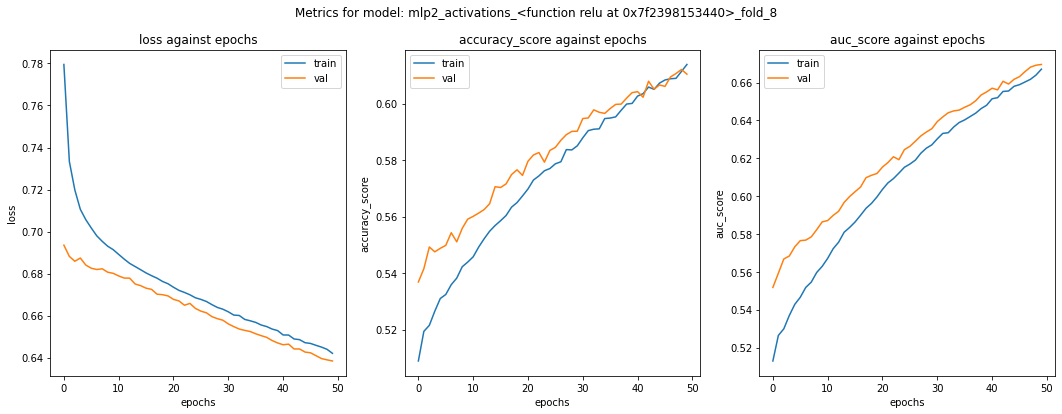

training model fold 9
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8148 - accuracy: 0.5082 - auc: 0.5107 - val_loss: 0.6976 - val_accuracy: 0.5280 - val_auc: 0.5451
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7375 - accuracy: 0.5181 - auc: 0.5253 - val_loss: 0.6902 - val_accuracy: 0.5387 - val_auc: 0.5586
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7226 - accuracy: 0.5228 - auc: 0.5306 - val_loss: 0.6859 - val_accuracy: 0.5477 - val_auc: 0.5693
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7120 - accuracy: 0.5264 - auc: 0.5357 - val_loss: 0.6874 - val_accuracy: 0.5461 - val_auc: 0.5672
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7059 - accuracy: 0.5304 - auc: 0.5428 - val_loss: 0.6845 - val_accuracy: 0.5503 - val_auc: 0.5741
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7015 - accuracy: 0.5331 - auc: 0

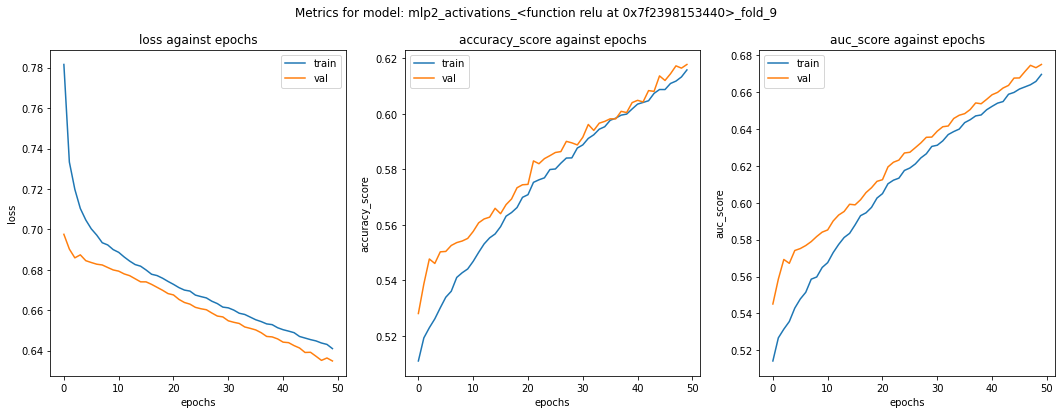

training model fold 10
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8054 - accuracy: 0.5083 - auc: 0.5117 - val_loss: 0.6932 - val_accuracy: 0.5356 - val_auc: 0.5520
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7375 - accuracy: 0.5174 - auc: 0.5252 - val_loss: 0.6881 - val_accuracy: 0.5461 - val_auc: 0.5640
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7185 - accuracy: 0.5230 - auc: 0.5330 - val_loss: 0.6855 - val_accuracy: 0.5466 - val_auc: 0.5701
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7113 - accuracy: 0.5261 - auc: 0.5358 - val_loss: 0.6851 - val_accuracy: 0.5492 - val_auc: 0.5680
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7041 - accuracy: 0.5317 - auc: 0.5443 - val_loss: 0.6845 - val_accuracy: 0.5497 - val_auc: 0.5735
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.6989 - accuracy: 0.5363 - auc: 

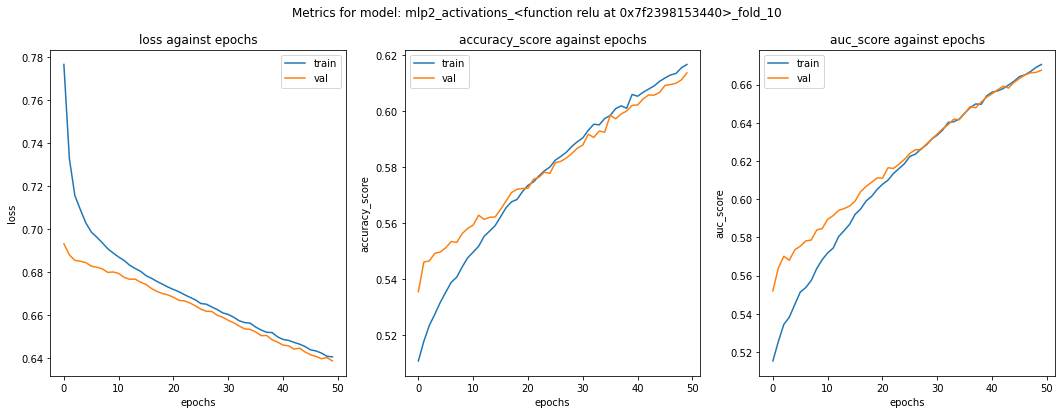

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [1260.9895004743275, 0.6133691135979829, 0.6128488146088455, 9080.2, 8053.1, 5627.1, 5172.7]
saved model metrics

model_name:  mlp2_activations_<function sigmoid at 0x7f23981537a0>
model_params:  batch_size=512, hidden_unit=[200, 400, 800, 400], activation=<function sigmoid at 0x7f23981537a0>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.7893 - accuracy: 0.5050 - auc: 0.5067 - val_loss: 0.6934 - val_accuracy: 0.5251 - val_auc: 0.5354
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7428 - accuracy: 0.5092 - auc: 0.5139 - val_loss: 0.6903 - val_accuracy: 0.5322 - val_auc: 0.5468
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7300 - accuracy: 0.5157 - auc: 0.5212 - val_loss: 0.6905 - val_accuracy: 0.5378 - val_a

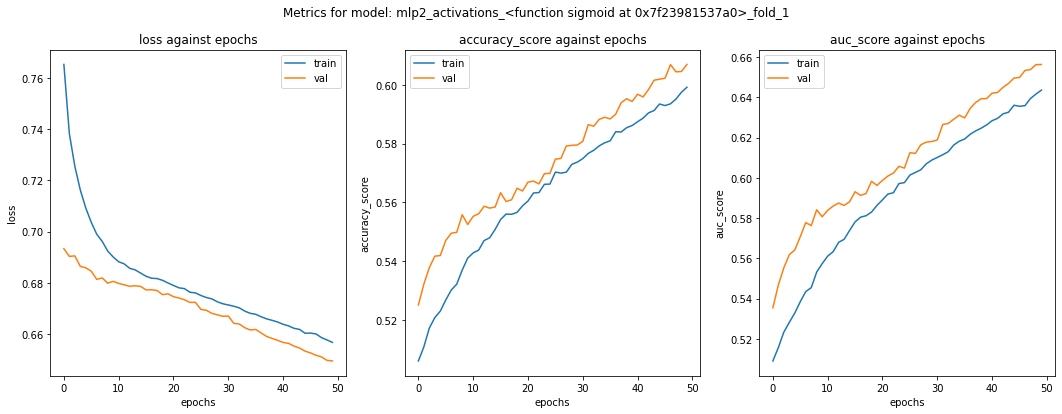

training model fold 2
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.7943 - accuracy: 0.5060 - auc: 0.5078 - val_loss: 0.6930 - val_accuracy: 0.5222 - val_auc: 0.5333
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7445 - accuracy: 0.5124 - auc: 0.5171 - val_loss: 0.6896 - val_accuracy: 0.5372 - val_auc: 0.5543
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7311 - accuracy: 0.5154 - auc: 0.5203 - val_loss: 0.6864 - val_accuracy: 0.5424 - val_auc: 0.5622
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7191 - accuracy: 0.5216 - auc: 0.5289 - val_loss: 0.6860 - val_accuracy: 0.5451 - val_auc: 0.5642
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7125 - accuracy: 0.5218 - auc: 0.5319 - val_loss: 0.6826 - val_accuracy: 0.5509 - val_auc: 0.5767
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7069 - accuracy: 0.5225 - auc: 0

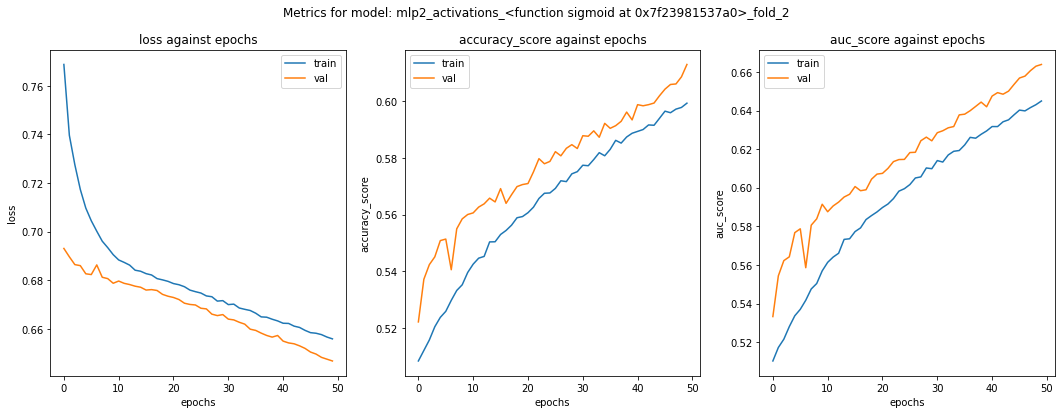

training model fold 3
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.7932 - accuracy: 0.5051 - auc: 0.5067 - val_loss: 0.6951 - val_accuracy: 0.5218 - val_auc: 0.5336
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7413 - accuracy: 0.5108 - auc: 0.5160 - val_loss: 0.6903 - val_accuracy: 0.5381 - val_auc: 0.5546
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7287 - accuracy: 0.5137 - auc: 0.5187 - val_loss: 0.6961 - val_accuracy: 0.5291 - val_auc: 0.5464
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7211 - accuracy: 0.5169 - auc: 0.5248 - val_loss: 0.6852 - val_accuracy: 0.5457 - val_auc: 0.5677
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7112 - accuracy: 0.5232 - auc: 0.5316 - val_loss: 0.6880 - val_accuracy: 0.5415 - val_auc: 0.5619
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7064 - accuracy: 0.5236 - auc: 0

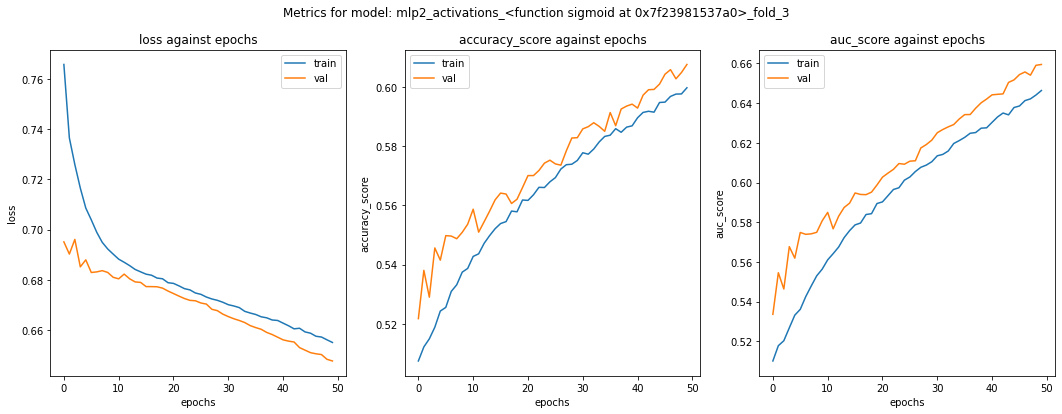

training model fold 4
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.7947 - accuracy: 0.5035 - auc: 0.5057 - val_loss: 0.6938 - val_accuracy: 0.5262 - val_auc: 0.5376
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7443 - accuracy: 0.5104 - auc: 0.5148 - val_loss: 0.6893 - val_accuracy: 0.5338 - val_auc: 0.5524
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7336 - accuracy: 0.5134 - auc: 0.5172 - val_loss: 0.6886 - val_accuracy: 0.5418 - val_auc: 0.5597
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7224 - accuracy: 0.5151 - auc: 0.5210 - val_loss: 0.6890 - val_accuracy: 0.5353 - val_auc: 0.5549
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7126 - accuracy: 0.5219 - auc: 0.5302 - val_loss: 0.6850 - val_accuracy: 0.5476 - val_auc: 0.5699
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7062 - accuracy: 0.5242 - auc: 0

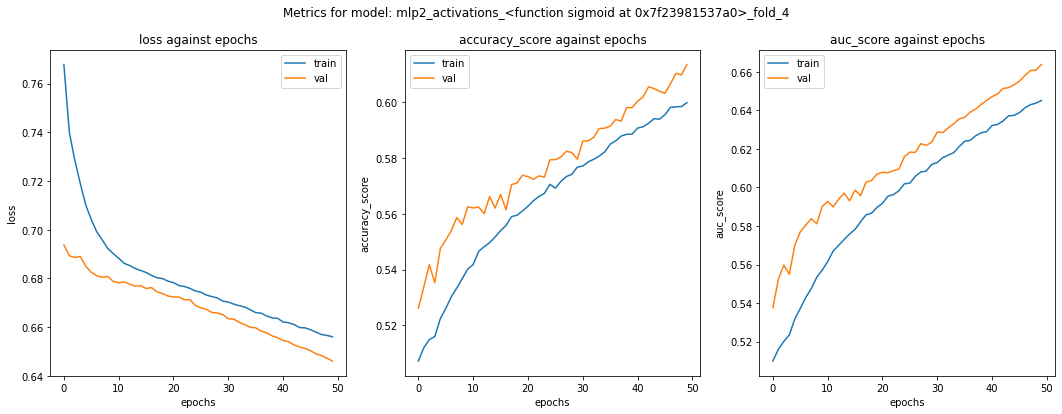

training model fold 5
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.7933 - accuracy: 0.5057 - auc: 0.5072 - val_loss: 0.6949 - val_accuracy: 0.5249 - val_auc: 0.5348
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7484 - accuracy: 0.5095 - auc: 0.5135 - val_loss: 0.6903 - val_accuracy: 0.5357 - val_auc: 0.5492
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7328 - accuracy: 0.5128 - auc: 0.5182 - val_loss: 0.6901 - val_accuracy: 0.5339 - val_auc: 0.5510
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7223 - accuracy: 0.5185 - auc: 0.5249 - val_loss: 0.6917 - val_accuracy: 0.5396 - val_auc: 0.5531
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7134 - accuracy: 0.5231 - auc: 0.5320 - val_loss: 0.6852 - val_accuracy: 0.5461 - val_auc: 0.5678
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7075 - accuracy: 0.5246 - auc: 0

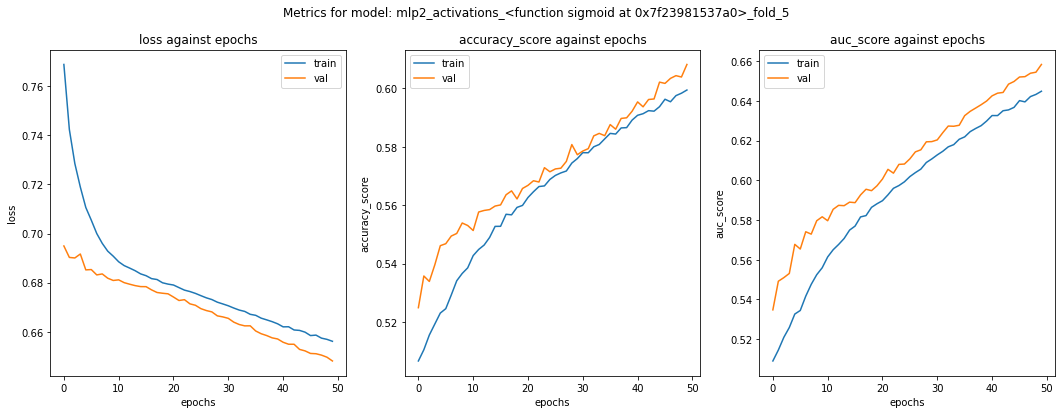

training model fold 6
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.7863 - accuracy: 0.5062 - auc: 0.5068 - val_loss: 0.6934 - val_accuracy: 0.5278 - val_auc: 0.5358
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7395 - accuracy: 0.5118 - auc: 0.5160 - val_loss: 0.6926 - val_accuracy: 0.5304 - val_auc: 0.5422
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7265 - accuracy: 0.5158 - auc: 0.5225 - val_loss: 0.6938 - val_accuracy: 0.5378 - val_auc: 0.5538
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7196 - accuracy: 0.5182 - auc: 0.5249 - val_loss: 0.6870 - val_accuracy: 0.5439 - val_auc: 0.5631
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7097 - accuracy: 0.5248 - auc: 0.5335 - val_loss: 0.6880 - val_accuracy: 0.5391 - val_auc: 0.5571
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7048 - accuracy: 0.5244 - auc: 0

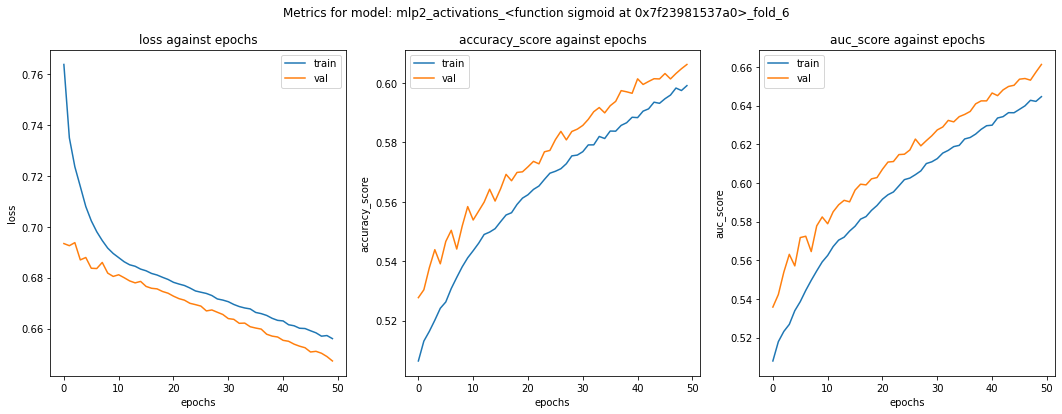

training model fold 7
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.7849 - accuracy: 0.5036 - auc: 0.5063 - val_loss: 0.6931 - val_accuracy: 0.5293 - val_auc: 0.5401
Epoch 2/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7412 - accuracy: 0.5106 - auc: 0.5151 - val_loss: 0.6908 - val_accuracy: 0.5381 - val_auc: 0.5495
Epoch 3/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7273 - accuracy: 0.5152 - auc: 0.5217 - val_loss: 0.6905 - val_accuracy: 0.5331 - val_auc: 0.5478
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7186 - accuracy: 0.5172 - auc: 0.5253 - val_loss: 0.6872 - val_accuracy: 0.5362 - val_auc: 0.5583
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7097 - accuracy: 0.5252 - auc: 0.5338 - val_loss: 0.6856 - val_accuracy: 0.5441 - val_auc: 0.5647
Epoch 6/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7035 - accuracy: 0.5270 - auc: 0

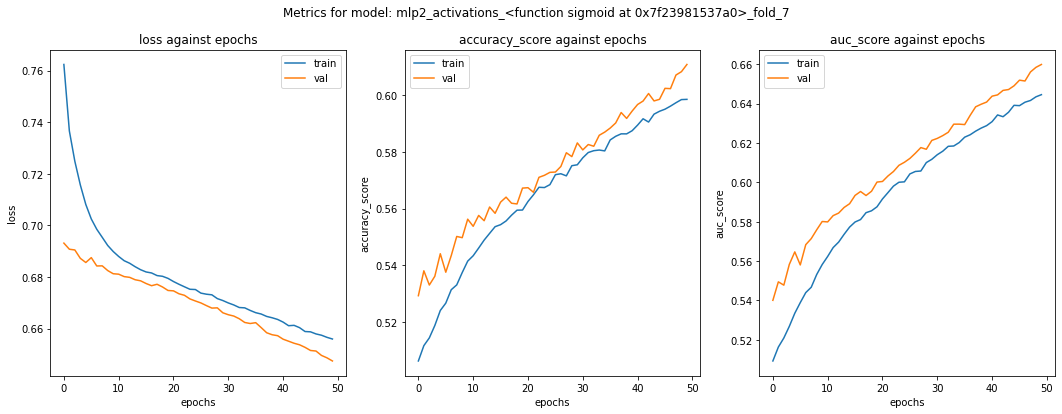

training model fold 8
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.7883 - accuracy: 0.5054 - auc: 0.5074 - val_loss: 0.6899 - val_accuracy: 0.5302 - val_auc: 0.5447
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7429 - accuracy: 0.5105 - auc: 0.5148 - val_loss: 0.6922 - val_accuracy: 0.5288 - val_auc: 0.5430
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7291 - accuracy: 0.5158 - auc: 0.5214 - val_loss: 0.6895 - val_accuracy: 0.5388 - val_auc: 0.5545
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7192 - accuracy: 0.5187 - auc: 0.5272 - val_loss: 0.6874 - val_accuracy: 0.5403 - val_auc: 0.5624
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7113 - accuracy: 0.5236 - auc: 0.5322 - val_loss: 0.6854 - val_accuracy: 0.5433 - val_auc: 0.5659
Epoch 6/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7055 - accuracy: 0.5255 - auc: 0

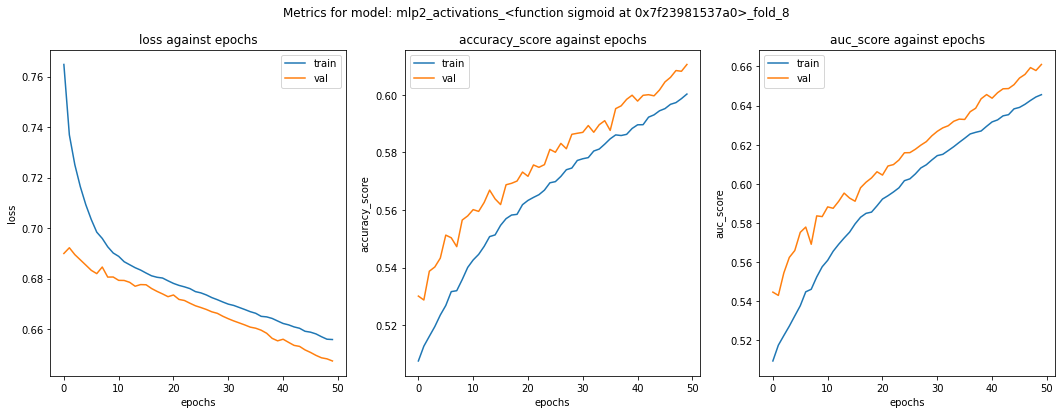

training model fold 9
Epoch 1/50
492/492 [==============================] - 7s 10ms/step - loss: 0.7853 - accuracy: 0.5090 - auc: 0.5108 - val_loss: 0.6925 - val_accuracy: 0.5257 - val_auc: 0.5362
Epoch 2/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7431 - accuracy: 0.5107 - auc: 0.5155 - val_loss: 0.6895 - val_accuracy: 0.5386 - val_auc: 0.5547
Epoch 3/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7294 - accuracy: 0.5166 - auc: 0.5217 - val_loss: 0.6883 - val_accuracy: 0.5404 - val_auc: 0.5582
Epoch 4/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7193 - accuracy: 0.5198 - auc: 0.5268 - val_loss: 0.6865 - val_accuracy: 0.5456 - val_auc: 0.5669
Epoch 5/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7107 - accuracy: 0.5238 - auc: 0.5333 - val_loss: 0.6848 - val_accuracy: 0.5498 - val_auc: 0.5704
Epoch 6/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7057 - accuracy: 0.5263 - auc: 

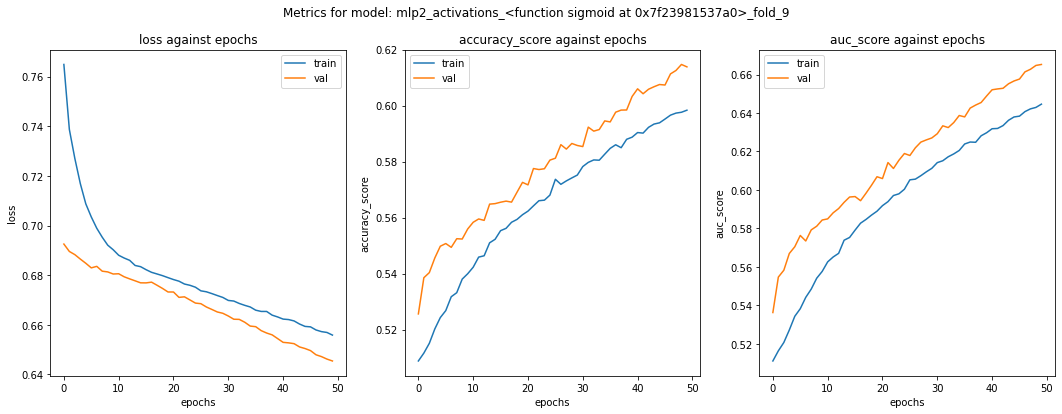

training model fold 10
Epoch 1/50
492/492 [==============================] - 6s 10ms/step - loss: 0.7840 - accuracy: 0.5030 - auc: 0.5049 - val_loss: 0.6957 - val_accuracy: 0.5188 - val_auc: 0.5304
Epoch 2/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7369 - accuracy: 0.5122 - auc: 0.5157 - val_loss: 0.6916 - val_accuracy: 0.5332 - val_auc: 0.5473
Epoch 3/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7254 - accuracy: 0.5146 - auc: 0.5194 - val_loss: 0.6871 - val_accuracy: 0.5436 - val_auc: 0.5612
Epoch 4/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7168 - accuracy: 0.5181 - auc: 0.5252 - val_loss: 0.6886 - val_accuracy: 0.5400 - val_auc: 0.5576
Epoch 5/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7087 - accuracy: 0.5221 - auc: 0.5310 - val_loss: 0.6854 - val_accuracy: 0.5438 - val_auc: 0.5652
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7042 - accuracy: 0.5233 - auc:

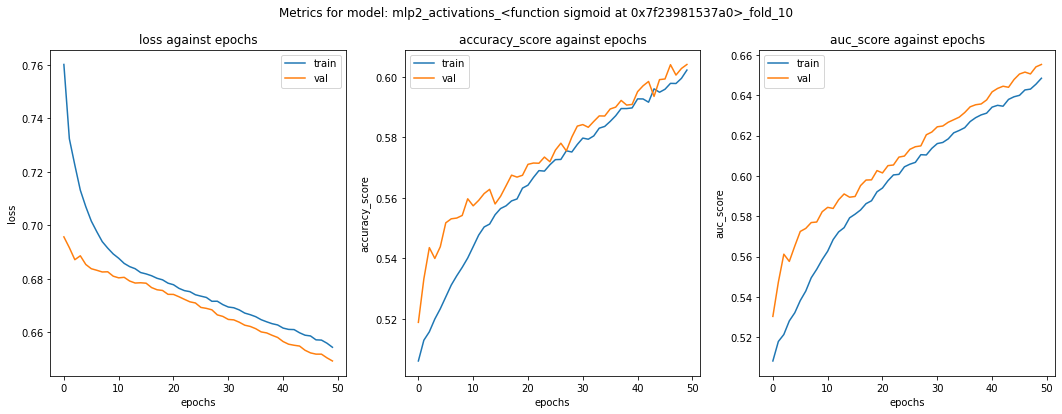

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [1207.0120484742401, 0.6094848137814741, 0.6089166194345269, 9061.7, 7963.1, 5717.1, 5191.2]
saved model metrics

model_name:  mlp2_activations_<function tanh at 0x7f2398153680>
model_params:  batch_size=512, hidden_unit=[200, 400, 800, 400], activation=<function tanh at 0x7f2398153680>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 7s 10ms/step - loss: 0.7885 - accuracy: 0.5059 - auc: 0.5085 - val_loss: 0.6966 - val_accuracy: 0.5272 - val_auc: 0.5402
Epoch 2/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7403 - accuracy: 0.5104 - auc: 0.5157 - val_loss: 0.6889 - val_accuracy: 0.5413 - val_auc: 0.5617
Epoch 3/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7247 - accuracy: 0.5183 - auc: 0.5242 - val_loss: 0.6899 - val_accuracy: 0.5426 - val_auc: 0

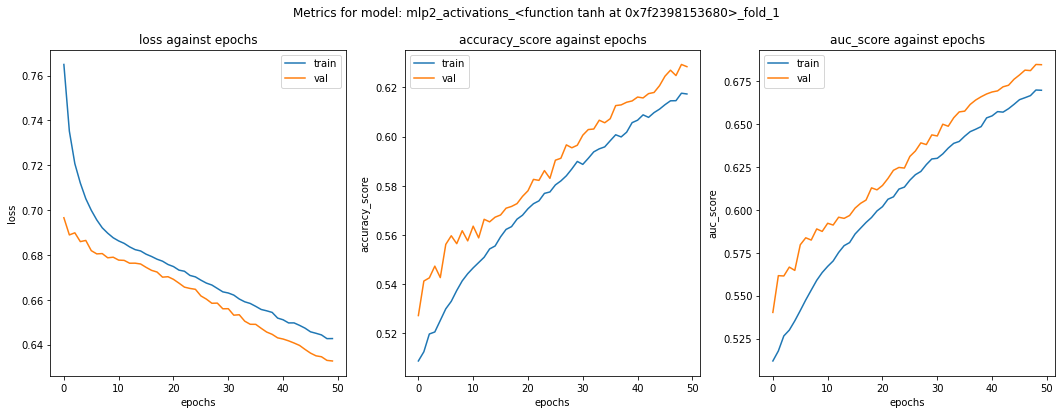

training model fold 2
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.7971 - accuracy: 0.5072 - auc: 0.5080 - val_loss: 0.6978 - val_accuracy: 0.5302 - val_auc: 0.5442
Epoch 2/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7454 - accuracy: 0.5092 - auc: 0.5133 - val_loss: 0.6912 - val_accuracy: 0.5417 - val_auc: 0.5604
Epoch 3/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7280 - accuracy: 0.5165 - auc: 0.5215 - val_loss: 0.6868 - val_accuracy: 0.5458 - val_auc: 0.5677
Epoch 4/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7154 - accuracy: 0.5203 - auc: 0.5280 - val_loss: 0.6836 - val_accuracy: 0.5544 - val_auc: 0.5764
Epoch 5/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7066 - accuracy: 0.5261 - auc: 0.5358 - val_loss: 0.6844 - val_accuracy: 0.5503 - val_auc: 0.5713
Epoch 6/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7006 - accuracy: 0.5301 - auc: 0

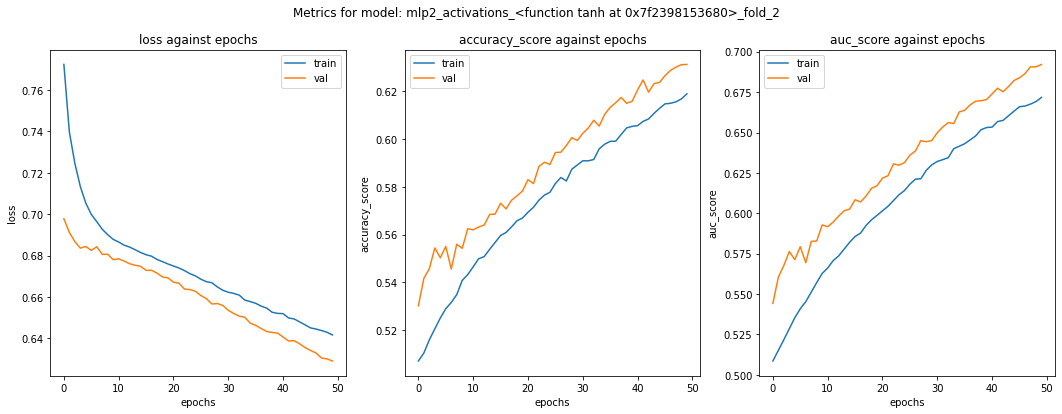

training model fold 3
Epoch 1/50
492/492 [==============================] - 7s 10ms/step - loss: 0.8047 - accuracy: 0.5046 - auc: 0.5076 - val_loss: 0.7009 - val_accuracy: 0.5269 - val_auc: 0.5395
Epoch 2/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7498 - accuracy: 0.5094 - auc: 0.5129 - val_loss: 0.6962 - val_accuracy: 0.5322 - val_auc: 0.5473
Epoch 3/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7312 - accuracy: 0.5163 - auc: 0.5206 - val_loss: 0.6958 - val_accuracy: 0.5350 - val_auc: 0.5497
Epoch 4/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7215 - accuracy: 0.5176 - auc: 0.5244 - val_loss: 0.6880 - val_accuracy: 0.5410 - val_auc: 0.5622
Epoch 5/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7092 - accuracy: 0.5249 - auc: 0.5345 - val_loss: 0.6876 - val_accuracy: 0.5412 - val_auc: 0.5636
Epoch 6/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7030 - accuracy: 0.5288 - auc: 

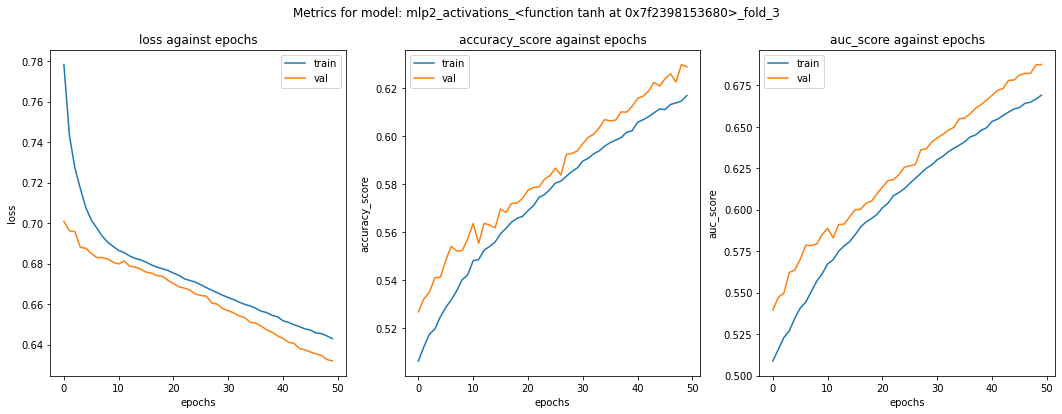

training model fold 4
Epoch 1/50
492/492 [==============================] - 6s 10ms/step - loss: 0.7970 - accuracy: 0.5051 - auc: 0.5080 - val_loss: 0.6995 - val_accuracy: 0.5331 - val_auc: 0.5457
Epoch 2/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7450 - accuracy: 0.5124 - auc: 0.5173 - val_loss: 0.6903 - val_accuracy: 0.5442 - val_auc: 0.5609
Epoch 3/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7294 - accuracy: 0.5152 - auc: 0.5218 - val_loss: 0.6881 - val_accuracy: 0.5483 - val_auc: 0.5680
Epoch 4/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7168 - accuracy: 0.5215 - auc: 0.5285 - val_loss: 0.6861 - val_accuracy: 0.5467 - val_auc: 0.5687
Epoch 5/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7084 - accuracy: 0.5241 - auc: 0.5341 - val_loss: 0.6877 - val_accuracy: 0.5465 - val_auc: 0.5686
Epoch 6/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7031 - accuracy: 0.5272 - auc: 

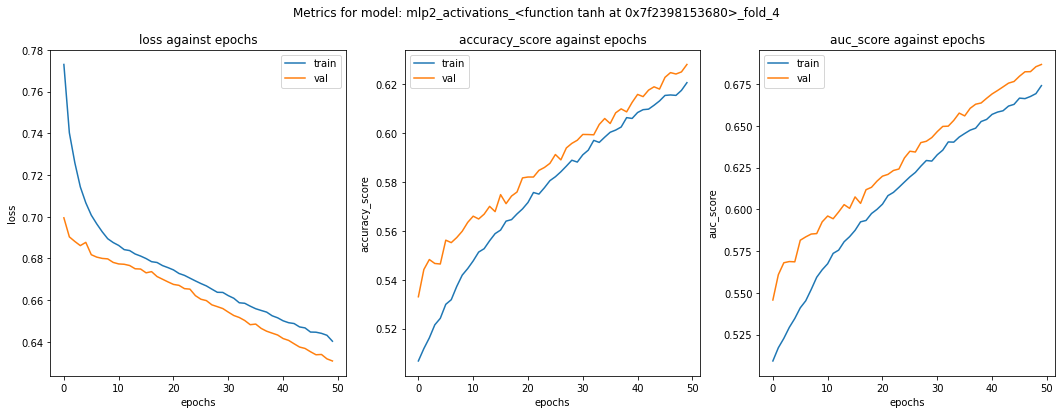

training model fold 5
Epoch 1/50
492/492 [==============================] - 7s 11ms/step - loss: 0.7993 - accuracy: 0.5049 - auc: 0.5071 - val_loss: 0.7023 - val_accuracy: 0.5252 - val_auc: 0.5367
Epoch 2/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7455 - accuracy: 0.5127 - auc: 0.5182 - val_loss: 0.6958 - val_accuracy: 0.5355 - val_auc: 0.5492
Epoch 3/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7296 - accuracy: 0.5165 - auc: 0.5227 - val_loss: 0.6877 - val_accuracy: 0.5419 - val_auc: 0.5618
Epoch 4/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7192 - accuracy: 0.5186 - auc: 0.5265 - val_loss: 0.6894 - val_accuracy: 0.5404 - val_auc: 0.5603
Epoch 5/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7083 - accuracy: 0.5250 - auc: 0.5355 - val_loss: 0.6843 - val_accuracy: 0.5499 - val_auc: 0.5734
Epoch 6/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7019 - accuracy: 0.5301 - 

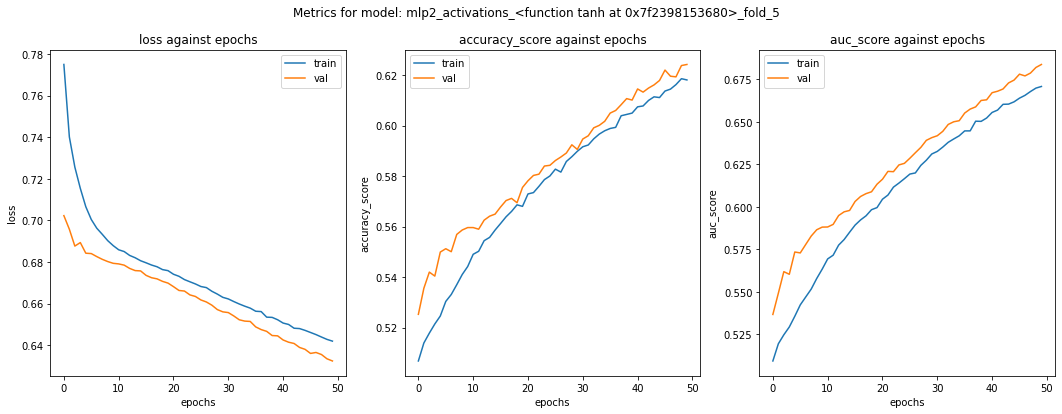

training model fold 6
Epoch 1/50
492/492 [==============================] - 7s 10ms/step - loss: 0.7968 - accuracy: 0.5061 - auc: 0.5073 - val_loss: 0.7029 - val_accuracy: 0.5316 - val_auc: 0.5435
Epoch 2/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7438 - accuracy: 0.5134 - auc: 0.5180 - val_loss: 0.6951 - val_accuracy: 0.5379 - val_auc: 0.5511
Epoch 3/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7302 - accuracy: 0.5138 - auc: 0.5194 - val_loss: 0.6924 - val_accuracy: 0.5417 - val_auc: 0.5608
Epoch 4/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7169 - accuracy: 0.5213 - auc: 0.5300 - val_loss: 0.6842 - val_accuracy: 0.5520 - val_auc: 0.5736
Epoch 5/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7089 - accuracy: 0.5229 - auc: 0.5334 - val_loss: 0.6847 - val_accuracy: 0.5443 - val_auc: 0.5677
Epoch 6/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7019 - accuracy: 0.5312 - auc: 

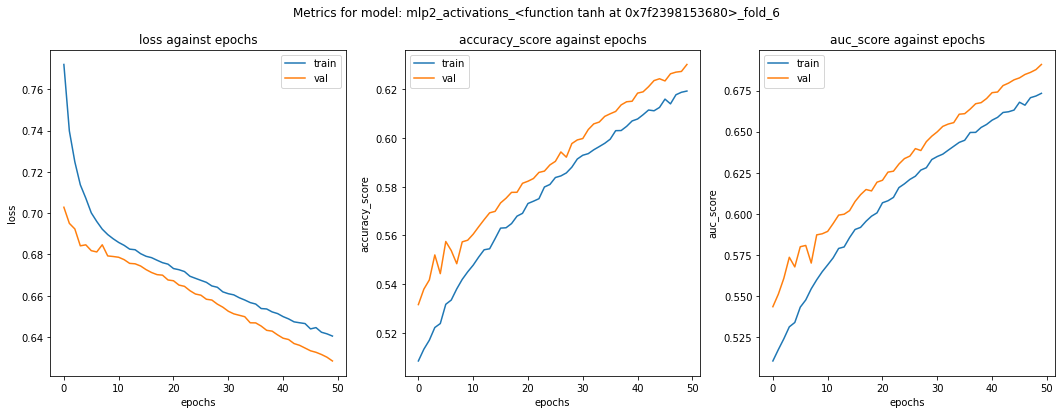

training model fold 7
Epoch 1/50
492/492 [==============================] - 7s 11ms/step - loss: 0.8001 - accuracy: 0.5081 - auc: 0.5084 - val_loss: 0.7045 - val_accuracy: 0.5318 - val_auc: 0.5455
Epoch 2/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7441 - accuracy: 0.5154 - auc: 0.5203 - val_loss: 0.6933 - val_accuracy: 0.5382 - val_auc: 0.5540
Epoch 3/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7287 - accuracy: 0.5181 - auc: 0.5247 - val_loss: 0.6893 - val_accuracy: 0.5441 - val_auc: 0.5597
Epoch 4/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7172 - accuracy: 0.5189 - auc: 0.5276 - val_loss: 0.6871 - val_accuracy: 0.5444 - val_auc: 0.5631
Epoch 5/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7074 - accuracy: 0.5290 - auc: 0.5391 - val_loss: 0.6846 - val_accuracy: 0.5462 - val_auc: 0.5705
Epoch 6/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7010 - accuracy: 0.5320 - a

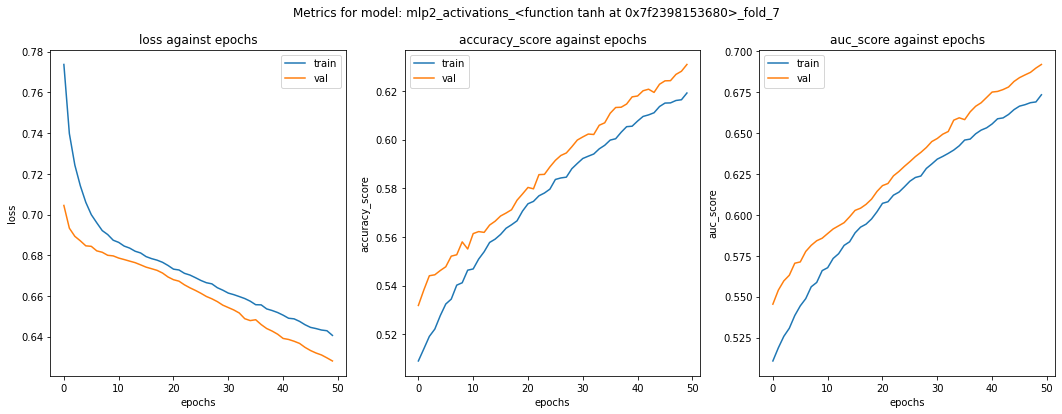

training model fold 8
Epoch 1/50
492/492 [==============================] - 7s 10ms/step - loss: 0.8094 - accuracy: 0.5035 - auc: 0.5035 - val_loss: 0.6969 - val_accuracy: 0.5283 - val_auc: 0.5438
Epoch 2/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7499 - accuracy: 0.5138 - auc: 0.5177 - val_loss: 0.6984 - val_accuracy: 0.5344 - val_auc: 0.5442
Epoch 3/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7330 - accuracy: 0.5172 - auc: 0.5231 - val_loss: 0.6892 - val_accuracy: 0.5411 - val_auc: 0.5609
Epoch 4/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7193 - accuracy: 0.5222 - auc: 0.5307 - val_loss: 0.6860 - val_accuracy: 0.5486 - val_auc: 0.5696
Epoch 5/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7108 - accuracy: 0.5250 - auc: 0.5341 - val_loss: 0.6843 - val_accuracy: 0.5555 - val_auc: 0.5732
Epoch 6/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7031 - accuracy: 0.5296 - auc:

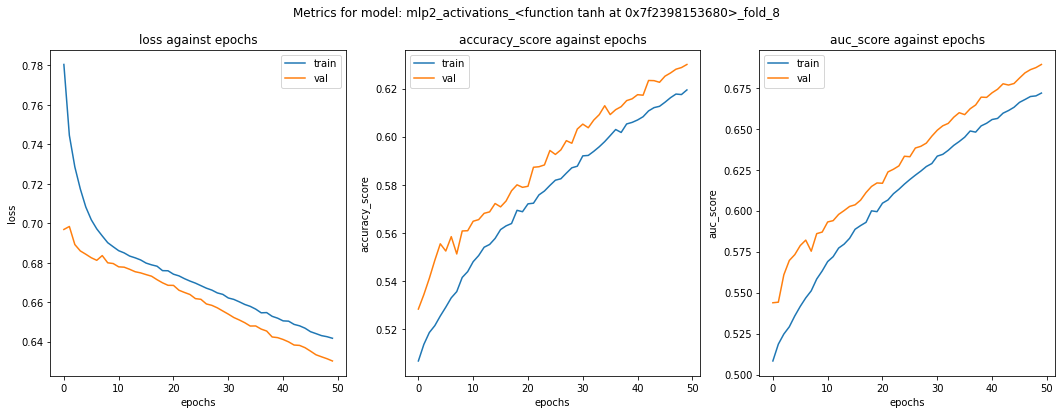

training model fold 9
Epoch 1/50
492/492 [==============================] - 7s 11ms/step - loss: 0.7977 - accuracy: 0.5059 - auc: 0.5071 - val_loss: 0.7003 - val_accuracy: 0.5322 - val_auc: 0.5444
Epoch 2/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7463 - accuracy: 0.5106 - auc: 0.5153 - val_loss: 0.6912 - val_accuracy: 0.5406 - val_auc: 0.5584
Epoch 3/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7275 - accuracy: 0.5183 - auc: 0.5235 - val_loss: 0.6921 - val_accuracy: 0.5366 - val_auc: 0.5555
Epoch 4/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7160 - accuracy: 0.5207 - auc: 0.5303 - val_loss: 0.6872 - val_accuracy: 0.5450 - val_auc: 0.5655
Epoch 5/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7083 - accuracy: 0.5239 - auc: 0.5330 - val_loss: 0.6850 - val_accuracy: 0.5463 - val_auc: 0.5703
Epoch 6/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7021 - accuracy: 0.5285 - au

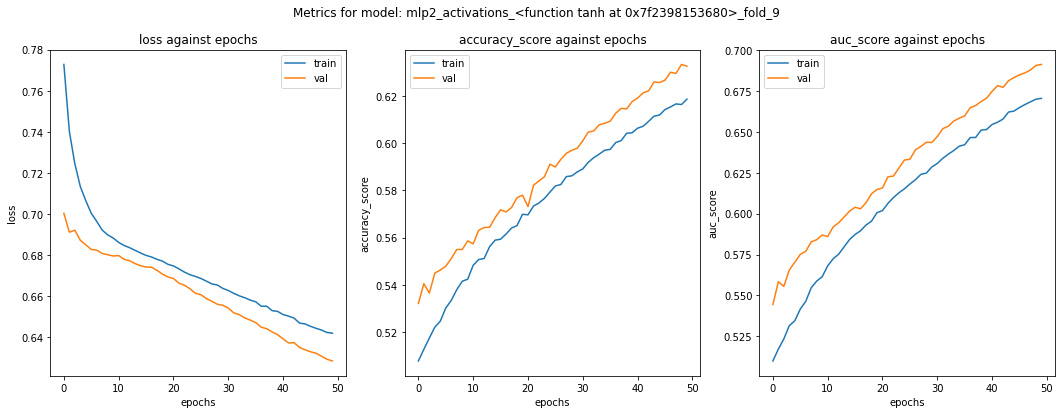

training model fold 10
Epoch 1/50
492/492 [==============================] - 7s 11ms/step - loss: 0.8023 - accuracy: 0.5049 - auc: 0.5076 - val_loss: 0.7026 - val_accuracy: 0.5285 - val_auc: 0.5400
Epoch 2/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7487 - accuracy: 0.5084 - auc: 0.5138 - val_loss: 0.6951 - val_accuracy: 0.5327 - val_auc: 0.5487
Epoch 3/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7308 - accuracy: 0.5158 - auc: 0.5213 - val_loss: 0.6913 - val_accuracy: 0.5406 - val_auc: 0.5562
Epoch 4/50
492/492 [==============================] - 6s 12ms/step - loss: 0.7195 - accuracy: 0.5211 - auc: 0.5274 - val_loss: 0.6874 - val_accuracy: 0.5419 - val_auc: 0.5621
Epoch 5/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7081 - accuracy: 0.5262 - auc: 0.5368 - val_loss: 0.6865 - val_accuracy: 0.5450 - val_auc: 0.5650
Epoch 6/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7027 - accuracy: 0.5289 - 

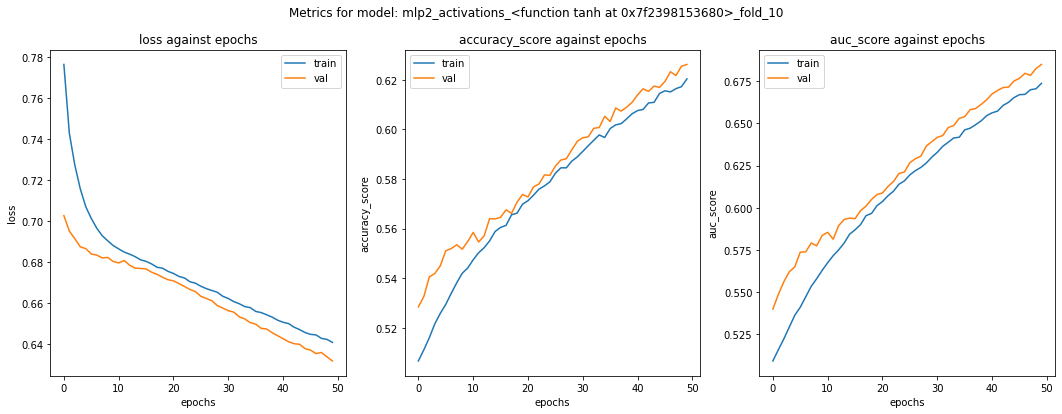

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [1399.1684822011084, 0.6290565696136355, 0.6285944477022819, 9272.3, 8299.2, 5381.0, 4980.6]
saved model metrics


In [ ]:
for batch_size in batch_sizes:
  for hidden_unit in hidden_units:
    for activation in activations:
      for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
          for epoch in epochs:

            output_filename = "CV_SCORES_AVE_NNDL.csv"
            workbook_name = "12E_nndl_cv_mlp2_activations"
            model_name = f"mlp2_activations_{activation}"
            model_params = f"batch_size={batch_size}, hidden_unit={hidden_unit}, activation={activation}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, epoch={epoch}"
                    
            print("")
            print("model_name: ", model_name)
            print("model_params: ", model_params)

            # cross validation
            cv_scores = []

            for i, (train_idx, val_idx) in enumerate(kf.split(x_train)):
              # train-val data (for utility score calculation) 
              train_cv, val_cv = train.iloc[train_idx], train.iloc[val_idx]
              # train-val features 
              x_train_cv, x_val_cv, y_train_cv, y_val_cv = x_train[train_idx], x_train[val_idx], y_train[train_idx], y_train[val_idx]

              # scaling data to make it easier for models to train
              scaler = StandardScaler().fit(x_train_cv)
              x_train_cv = scaler.transform(x_train_cv)

              # test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
              x_val_cv = scaler.transform(x_val_cv)

              print(f"training model fold {i+1}")

              model = create_mlp(x_train_cv.shape[1], hidden_unit, activation, dropout_rate, learning_rate)
              model_name_fold = model_name + f"_fold_{i+1}"
              # CheckpointCallback = ModelCheckpoint(str(PATH_CHECKPOINTS / (model_name + '.hdf5')), monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', save_freq='epoch')

              history = model.fit(
                  x_train_cv, 
                  y_train_cv, 
                  epochs=epoch, 
                  batch_size=batch_size,
                  validation_data=(x_val_cv, y_val_cv),
                  # callbacks = [CheckpointCallback]
              )

              model_score = model_scores(model, test=val_cv, x_test=x_val_cv, y_test=y_val_cv)
              cv_scores.append(model_score)

              history_saver(history, model_name_fold, PATH_HISTORIES, already_npy=False)
              history = history_loader(model_name_fold, PATH_HISTORIES)
              plot_metrics(history, model_name_fold, PATH_FIGURES)

            # mean of cv scores
            cv_scores_ave = [sum(ele) / len(cv_scores) for ele in zip(*cv_scores)]
            print("cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg")
            print("cv_scores_ave: ", cv_scores_ave)

            # save average scores
            save_scores(output_filename, workbook_name, model_name, model_params, *cv_scores_ave)


In [ ]:
# '''
# predict on the test set. load best weights from checkpoints
# '''
# # model.load_weights(str(PATH_CHECKPOINTS / (model_name + '.hdf5')))

# test_metrics = model.evaluate(x_test, steps=3)

# test_metrics_dict = {
#     'test_loss': test_metrics[0]
# }

# np.save(PATH_PREDICTIONS/str(model_name + "_prediction_score"), test_metrics_dict)

In [ ]:
# y_pred = (model.predict(x_test) > 0.5).astype(int)
# utility_score(test, y_pred)

# Conclusion

Best performing hyperparameters : activations=tanh
* Utility score: 1399.1684822011
* Accuracy: 0.629056569613635

Using tanh provides the best utility scores

Consistent with 11E, but performs better

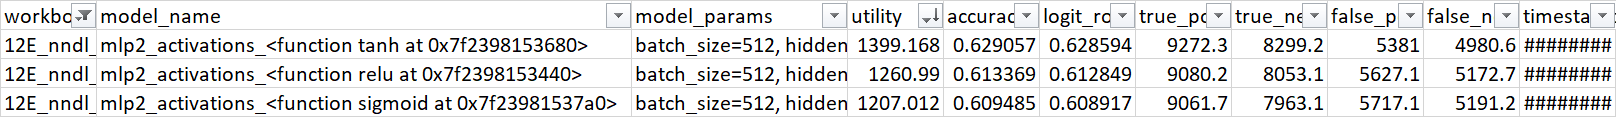